In [1]:
import os
import cv2
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

2024-02-04 22:30:40.041569: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 22:30:40.041678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 22:30:40.086545: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Lokacija dataset-a

In [2]:
dataset_path = "../data_set"

In [3]:
classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]


Inicijalizacija lista za cuvanje podataka


In [4]:
data = []
labels = []

Ucitavanje slika kroz klase


In [5]:
for class_name in classes:
    class_path = os.path.join(dataset_path, "Training", class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # Da sve slike budu 224x224px
        data.append(img)
        labels.append(classes.index(class_name))


Konvertovanje listi u numpy


In [6]:
data = np.array(data) / 255.0  # Normalizacija vrednosti piksela
labels = np.array(labels)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)


ImageDataGenerator za data augmentation


In [8]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

CNN model sa Dropout slojem


In [9]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dodajemo Dropout sloj sa dropout rate-om 0.5
model.add(Dense(len(classes), activation='softmax'))

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [11]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_val, y_val))


Epoch 1/50
72/72 [==============================] - 79s 1s/step - loss: 1.3412 - accuracy: 0.3484 - val_loss: 1.2233 - val_accuracy: 0.5105
Epoch 2/50
72/72 [==============================] - 72s 998ms/step - loss: 1.2444 - accuracy: 0.4207 - val_loss: 1.1325 - val_accuracy: 0.5697
Epoch 3/50
72/72 [==============================] - 86s 1s/step - loss: 1.1886 - accuracy: 0.4669 - val_loss: 1.0066 - val_accuracy: 0.5854
Epoch 4/50
72/72 [==============================] - 90s 1s/step - loss: 1.1397 - accuracy: 0.4782 - val_loss: 0.9644 - val_accuracy: 0.5871
Epoch 5/50
72/72 [==============================] - 88s 1s/step - loss: 1.0705 - accuracy: 0.5366 - val_loss: 1.0291 - val_accuracy: 0.5436
Epoch 6/50
72/72 [==============================] - 93s 1s/step - loss: 0.9969 - accuracy: 0.5666 - val_loss: 0.8419 - val_accuracy: 0.6707
Epoch 7/50
72/72 [==============================] - 86s 1s/step - loss: 0.9604 - accuracy: 0.5989 - val_loss: 0.7963 - val_accuracy: 0.6533
Epoch 8/50
72/72 

Evaluacija modela na test skupu

In [12]:
test_data = []
test_labels = []

In [13]:
for class_name in classes:
    class_path = os.path.join(dataset_path, "Testing", class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        test_data.append(img)
        test_labels.append(classes.index(class_name))


In [14]:
test_data = np.array(test_data) / 255.0
test_labels = np.array(test_labels)


In [15]:
loss, accuracy = model.evaluate(test_data, test_labels)

13/13 [==============================] - 2s 175ms/step - loss: 3.6337 - accuracy: 0.4949


In [16]:
print(f"Tacnost na test skupu sa Dropout-om: {accuracy}")


Tacnost na test skupu sa Dropout-om: 0.494923859834671


Rezultati

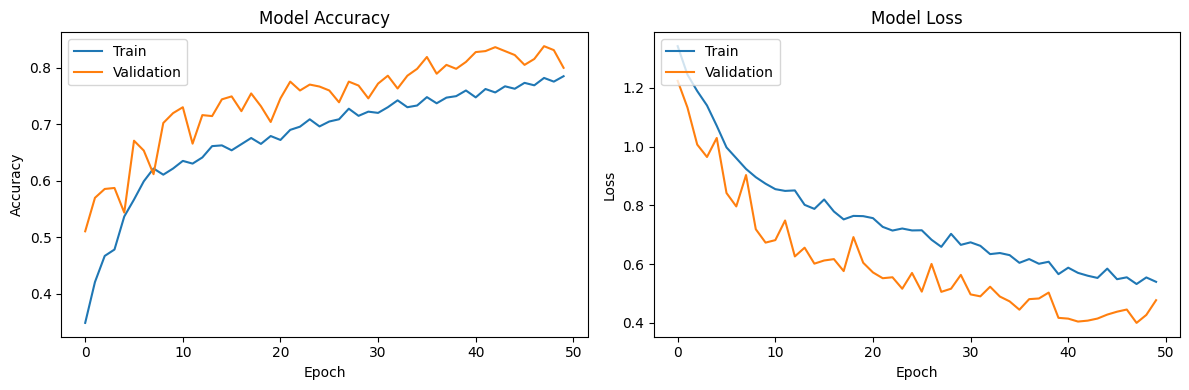

In [17]:
# Plotting the training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()